In [32]:
# take a cdf file
# read it in and plot
# then write to separate binary files
# then read it back in and plot 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [33]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

A = [0,1,2,3,4,5,6,7,8,9]

print (split_list(A, wanted_parts=1))
print (split_list(A, wanted_parts=4))
print (split_list(A, wanted_parts=8))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
[[0, 1], [2, 3, 4], [5, 6], [7, 8, 9]]
[[0], [1], [2], [3, 4], [5], [6], [7], [8, 9]]


In [34]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

In [35]:
def rect(T):
    """create a centered rectangular pulse of width $T"""
    return lambda t: (-T/2 <= t) & (t < T/2)

def pulse_train(t, at, shape):
    """create a train of pulses over $t at times $at and shape $shape"""
    return np.sum(shape(t - at[:,np.newaxis]), axis=0)

sig = pulse_train(
    t=np.arange(100),              # time domain
    at=np.array([0, 10, 40, 80]),  # times of pulses
    shape=rect(3)                 # shape of pulse
)

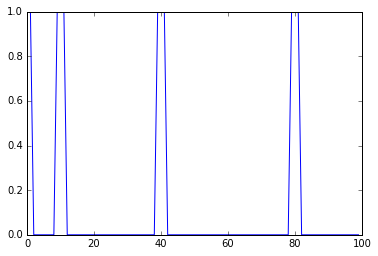

In [36]:
plt.plot (sig)

In [37]:
from bitstring import BitArray
from bitstring import Bits
from bitstring import BitStream
from bitstring import ConstBitStream



VersionNo          =BitArray('0b000')
TypeInd            =BitArray('0b0')
PackSecHdrFlag     =BitArray('0b1')
Apid               =BitArray('0b00100100100')
SequenceFlags      =BitArray('0b01')
SourceSequencCount =BitArray(int=5, length=14)
PacketDataLength   =Bits(int=1442, length=16)
PacketSecHeader    =Bits(int=12, length=16)
SourceData         =Bits(int=12, length=1442)

FirstSestet = VersionNo
PacketId = TypeInd
PacketId += PackSecHdrFlag
PacketId += Apid

FirstSestet += PacketId


PacketSecControl=SequenceFlags+SourceSequencCount

FirstSestet.bin

print(FirstSestet.bin)
print(PacketSecControl.bin)
print(PacketDataLength.bin)


Header=FirstSestet
Header += PacketSecControl
Header += PacketDataLength



file='ccsds2.bin'
with open(file,'wb') as f:
    FirstSestet.tofile(f)
    PacketSecControl.tofile(f)
    PacketDataLength.tofile(f)


0b0000100100100100
0b0100000000000101
0b0000010110100010


size 1450
[0 0 0 ..., 0 0 0]
fullsize  7250
5
850
use bitstring to bitpack the data
create file  ccsds_packed_bits0001.dat
 - write header, data to file
create file  ccsds_packed_bits0002.dat
 - write header, data to file
create file  ccsds_packed_bits0003.dat
 - write header, data to file
create file  ccsds_packed_bits0004.dat
 - write header, data to file
create file  ccsds_packed_bits0005.dat
 - write header, data to file


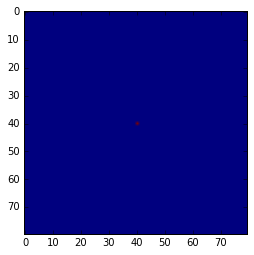

In [150]:
# declare 2d array of sample data



import numpy as np

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

a=makeGaussian(80,fwhm = 70, center=None)
a=4094*a.astype(int)

a.size
#a=np.eye(80,80)


plt.imshow(a)

size=1450

print ('size',size)

# flatten 2d array into 1d array

b=np.ravel(a)
print (b)

# break up into subsections 

lenb=len(b)

numfiles=int (np.ceil(lenb*1.0/size))

fullsize=size*numfiles


print ("fullsize ",fullsize)
print (numfiles)

diff=fullsize-lenb
print (diff)
zerodiff=np.zeros(diff)


# pad/extend file to fit exactly into required 
# space
c=np.append(b, zerodiff )


# take each element and pack it into 12 bits each
# 12*8 = 6*16 bits = 96 bits
# saves 25% of space


print ("use bitstring to bitpack the data")

import bitstring as bs

# create foramt string, unsigned int (uint) 12 bits long
format=str(size)+'*(uint:12)'
data_arr=range(size)

# test the packing function
e = bs.pack(format,*data_arr) 


for i in range(0, numfiles ):
    filename="ccsds_packed_bits"+str(i+1).zfill(4)+".dat" 
    print ("create file "+" "+filename)
    format=str(size)+'*(uint:12)'
    data_arr=c[i*size:(i+1)*size]
    packedbits = bs.pack(format,*data_arr)
    
    VersionNo          =BitArray('0b000')
    TypeInd            =BitArray('0b0')
    PackSecHdrFlag     =BitArray('0b1')
    Apid               =BitArray('0b00100100100')
    SequenceFlags      =BitArray('0b01')
    SourceSequencCount =BitArray(int=i, length=14)
    LengthInOctets     =size*12//8
    PacketDataLength   =Bits(int=LengthInOctets-1, length=16)
    PacketSecHeader    =Bits(int=12, length=16)
    SourceData         =Bits(int=12, length=1442)

    FirstSestet = VersionNo
    PacketId = TypeInd
    PacketId += PackSecHdrFlag
    PacketId += Apid

    FirstSestet += PacketId


    PacketSecControl=SequenceFlags+SourceSequencCount

    #print (data_arr)
    #print (packedbits)
    print (" - write header, data to file")
    with open(filename,'wb') as f:
        FirstSestet.tofile(f)
        PacketSecControl.tofile(f)
        PacketDataLength.tofile(f)
        PacketSecHeader.tofile(f)        
        packedbits.tofile(f)
        
    




read file  ccsds_packed_bits0001.dat
2174
0 0 1 292
1 0 2174
17400
read file  ccsds_packed_bits0002.dat
2174
0 0 1 292
1 1 2174
17400
read file  ccsds_packed_bits0003.dat
2174
0 0 1 292
1 2 2174
17400
read file  ccsds_packed_bits0004.dat
2174
0 0 1 292
1 3 2174
17400
read file  ccsds_packed_bits0005.dat
2174
0 0 1 292
1 4 2174
17400


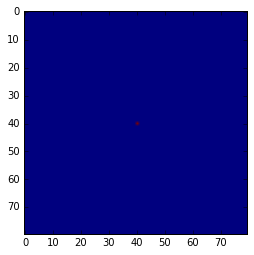

In [151]:
from bitstring import BitArray
from bitstring import Bits
from bitstring import BitStream
from bitstring import ConstBitStream



arr=[]

for i in range(0, numfiles ):
    import bitstring as bs
    filename="ccsds_packed_bits"+str(i+1).zfill(4)+".dat" 
    print ("read file "+" "+filename)
    #data_arr=c[i*size:(i+1)*size]
    #packedbits = bs.pack(format,*data_arr)
    s = ConstBitStream(filename=filename)
    VersionNo ,  TypeInd, PackSecHdrFlag,   Apid =s.readlist([3,1,1,11])
    SequenceFlags ,SourceSequencCount, PacketDataLength =s.readlist([2,14,16])
    print (PacketDataLength.uint)
    PacketSecHeader ,  SourceData         =s.readlist('bin:16,bits')
    print (VersionNo.uint, TypeInd.uint, PackSecHdrFlag.uint, Apid.uint)
    print (SequenceFlags.uint ,SourceSequencCount.uint, PacketDataLength.uint)
    LengthIn12BitInts=(PacketDataLength.uint+1)*8//12
    format=str(LengthIn12BitInts)+'*(uint:12)'
    print (SourceData.length)
    unpackedbits=SourceData.unpack(format)
    arr.append(unpackedbits)
    #print (unpackedbits)
    

    
im=np.asarray(arr)
im=im.ravel()
im2=im[0:80*80].copy()
im2=np.reshape(im2,(80,80))
plt.imshow(np.log10(im2+.1))

7250

(7250,)


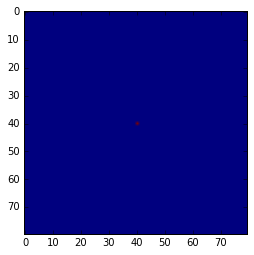

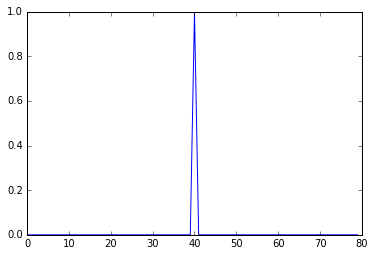

In [142]:
plt.plot(im2[40,:])